In [60]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated
import os
import operator

In [61]:
load_dotenv()

model = ChatGoogleGenerativeAI(model = 'gemini-2.0-flash')

In [62]:
class EvaluationSchema(BaseModel):

    feedback: str = Field(description = 'Detailed feedback for the essay')
    score: int = Field(description = 'Score out of 10', ge=0, le=10)

In [63]:
structured_model = model.with_structured_output(EvaluationSchema)

In [64]:
essay = """
    Artificial Intelligence in India: A Transformative Force
Introduction
Artificial Intelligence (AI) is no longer a futuristic concept—it's a present-day reality reshaping industries, governance, and daily life. In India, a country of over 1.4 billion people with diverse socio-economic challenges and immense digital potential, AI is emerging as a transformative force across sectors.
Growth and Adoption
India has witnessed a rapid surge in AI adoption, driven by both government initiatives and private sector innovation. From smart cities to digital agriculture, AI is being integrated into national development strategies. The National Strategy for Artificial Intelligence, launched by NITI Aayog, positions India as a hub for “AI for All,” emphasizing inclusive growth.
Key sectors embracing AI include:
- Healthcare: AI-powered diagnostics, predictive analytics, and telemedicine are improving access and outcomes, especially in rural areas.
- Agriculture: AI models help farmers with crop prediction, pest control, and irrigation management, enhancing productivity.
- Education: Personalized learning platforms and AI tutors are bridging gaps in access and quality.
- Finance: Fraud detection, credit scoring, and robo-advisors are revolutionizing banking and fintech.
- Governance: AI is being used for traffic management, surveillance, and citizen service delivery.
Startups and Innovation
India's startup ecosystem is thriving with over 1,500 AI startups as of 2025. Cities like Bengaluru, Hyderabad, and Pune are becoming AI innovation hubs. Companies are developing solutions tailored to Indian contexts—such as multilingual NLP models, low-resource machine learning, and affordable AI hardware.
Challenges
Despite the momentum, India faces several hurdles:
- Data Quality and Access: Many AI models require large, clean datasets, which are often unavailable or fragmented in India.
- Skilled Workforce: There's a growing demand for AI talent, but a shortage of skilled professionals in deep learning, data science, and AI ethics.
- Infrastructure Gaps: Limited access to high-performance computing and cloud infrastructure in Tier 2 and Tier 3 cities slows down innovation.
- Ethical and Regulatory Concerns: Issues around bias, privacy, and surveillance require robust frameworks and public discourse.
Government Initiatives
The Indian government is actively promoting AI through:
- IndiaAI Mission: A national program to support AI research, startups, and skilling.
- Digital India: Integrating AI into e-governance and public service delivery.
- AI Centers of Excellence: Established in collaboration with academia and industry to foster cutting-edge research.
Future Outlook
India's AI journey is poised for exponential growth. With its vast population, rich linguistic diversity, and unique challenges, India offers fertile ground for developing inclusive and ethical AI solutions. If harnessed responsibly, AI can be a powerful tool for social equity, economic growth, and global leadership.
Conclusion
Artificial Intelligence in India is not just about technology—it's about transformation. As the country balances innovation with inclusion, the future of AI in India will be defined by how well it serves its people, empowers its youth, and solves its most pressing problems.

"""

In [65]:
prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}"
output = structured_model.invoke(prompt)

In [66]:
output.score

7

In [67]:
output.feedback

'The essay provides a good overview of AI in India, covering growth, challenges, and government initiatives. The language is clear and accessible, making it easy to understand for a broad audience. However, the writing could be more engaging with stronger transitions between paragraphs and more specific examples to illustrate the points. The conclusion is a bit generic; it could be more impactful by summarizing the key arguments or offering a more forward-looking perspective.'

In [68]:
class UPSCState(TypedDict):

    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float

In [69]:
def evaluate_language(state: UPSCState):

    prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)

    return {'language_feedback': output.feedback, 'individual_scores': [output.score]}

In [70]:
def evaluate_analysis(state: UPSCState):

    prompt = f"Evaluate the language depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)

    return {'analysis_feedback': output.feedback, 'individual_scores': [output.score]}

In [71]:
def evaluate_thought(state: UPSCState):

    prompt = f"Evaluate the language clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}"
    output = structured_model.invoke(prompt)

    return {'clarity_feedback': output.feedback, 'individual_scores': [output.score]}

In [72]:
def final_evaluation(state: UPSCState):

    prompt = f"Based on the following feedbacks create a summarized feedback \n language feedback - {state['language_feedback']} \n depth of analysis feedback - {state['analysis_feedback']}  \n clarity of thought feedback - {state['clarity_feedback']}."
    overall_feedback = model.invoke(prompt).content

    #avg 
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {'overall_feedback': overall_feedback, 'avg_score': round(avg_score,4)}

In [73]:
graph = StateGraph(UPSCState)

#nodes
graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('final_evaluation', final_evaluation)

#edges
graph.add_edge(START, 'evaluate_language')
graph.add_edge('evaluate_language', 'final_evaluation')

graph.add_edge(START, 'evaluate_analysis')
graph.add_edge('evaluate_analysis', 'final_evaluation')

graph.add_edge(START, 'evaluate_thought')
graph.add_edge('evaluate_thought', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()


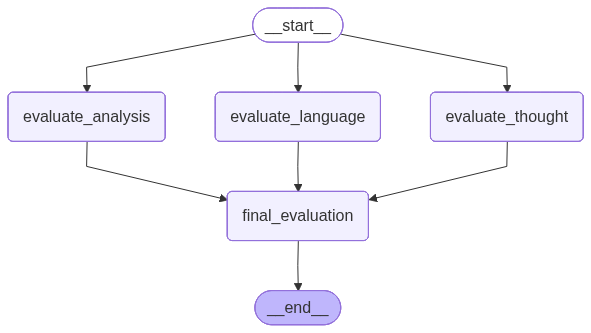

In [74]:
workflow

In [75]:
initial_state = {
    'essay': essay
}

workflow.invoke(initial_state)

{'essay': "\n    Artificial Intelligence in India: A Transformative Force\nIntroduction\nArtificial Intelligence (AI) is no longer a futuristic concept—it's a present-day reality reshaping industries, governance, and daily life. In India, a country of over 1.4 billion people with diverse socio-economic challenges and immense digital potential, AI is emerging as a transformative force across sectors.\nGrowth and Adoption\nIndia has witnessed a rapid surge in AI adoption, driven by both government initiatives and private sector innovation. From smart cities to digital agriculture, AI is being integrated into national development strategies. The National Strategy for Artificial Intelligence, launched by NITI Aayog, positions India as a hub for “AI for All,” emphasizing inclusive growth.\nKey sectors embracing AI include:\n- Healthcare: AI-powered diagnostics, predictive analytics, and telemedicine are improving access and outcomes, especially in rural areas.\n- Agriculture: AI models help

In [76]:
essay2 = """AI is big thing in India now. Many peoples use it for do work fast and smart. Before, peoples do thing slow and hard, but now AI come and make easy. Government also say AI is good and want to use it more.
In hospital, AI help doctor to look inside body and say what wrong. Farmer also use AI for grow food better. It tell when rain come or when bug eat plant. Student use AI for learn thing, like math and science, and AI talk like teacher but not real teacher.
Many company make AI stuff. Some in Bangalore, some in Mumbai, some in other place. They make robot brain and computer talk. But some peoples no have internet or phone, so they no can use AI good. Also, some AI say wrong thing or confuse people, so it not always perfect.
Government do plan like “Digital India” and “AI for All” which mean AI for every people, not just rich one. They make rule so AI no do bad thing. But still, some peoples worry AI take job and make problem.
In future, AI maybe do everything. Cook food, drive car, even write essay like this one. But peoples must be careful and use AI with brain, not just trust everything.
"""

In [77]:
initial_state_essay2 = {
    'essay': essay2
}


workflow.invoke(initial_state_essay2)


{'essay': 'AI is big thing in India now. Many peoples use it for do work fast and smart. Before, peoples do thing slow and hard, but now AI come and make easy. Government also say AI is good and want to use it more.\nIn hospital, AI help doctor to look inside body and say what wrong. Farmer also use AI for grow food better. It tell when rain come or when bug eat plant. Student use AI for learn thing, like math and science, and AI talk like teacher but not real teacher.\nMany company make AI stuff. Some in Bangalore, some in Mumbai, some in other place. They make robot brain and computer talk. But some peoples no have internet or phone, so they no can use AI good. Also, some AI say wrong thing or confuse people, so it not always perfect.\nGovernment do plan like “Digital India” and “AI for All” which mean AI for every people, not just rich one. They make rule so AI no do bad thing. But still, some peoples worry AI take job and make problem.\nIn future, AI maybe do everything. Cook food,